In [1]:
import numpy as np 
from minio_obj_storage import upload_numpy_as_blob, get_numpy_from_cloud

container_name = 'hiker-scores'
container_dir = 'imagenet'
lts = []
loss_grad = []
loss = []
loss_curvature = []
epochs = 200
for epoch in range(epochs):
    loss_grad_4_eph = get_numpy_from_cloud(container_name, container_dir, f"loss_grad_imagenet_resnet18_wd1_{epoch}.npy")
    loss_4_eph = get_numpy_from_cloud(container_name, container_dir, f"loss_imagenet_resnet18_wd1_{epoch}.npy")
    loss_grad.append(loss_grad_4_eph)
    loss.append(loss_4_eph)

loss_grads = np.array(loss_grad)
losses = np.array(loss)
loss_curvatures = np.array(loss_curvature)

In [2]:
learning_cond = np.cumsum(loss_grads, axis=0) / np.cumsum(np.ones_like(loss_grads), axis=0)

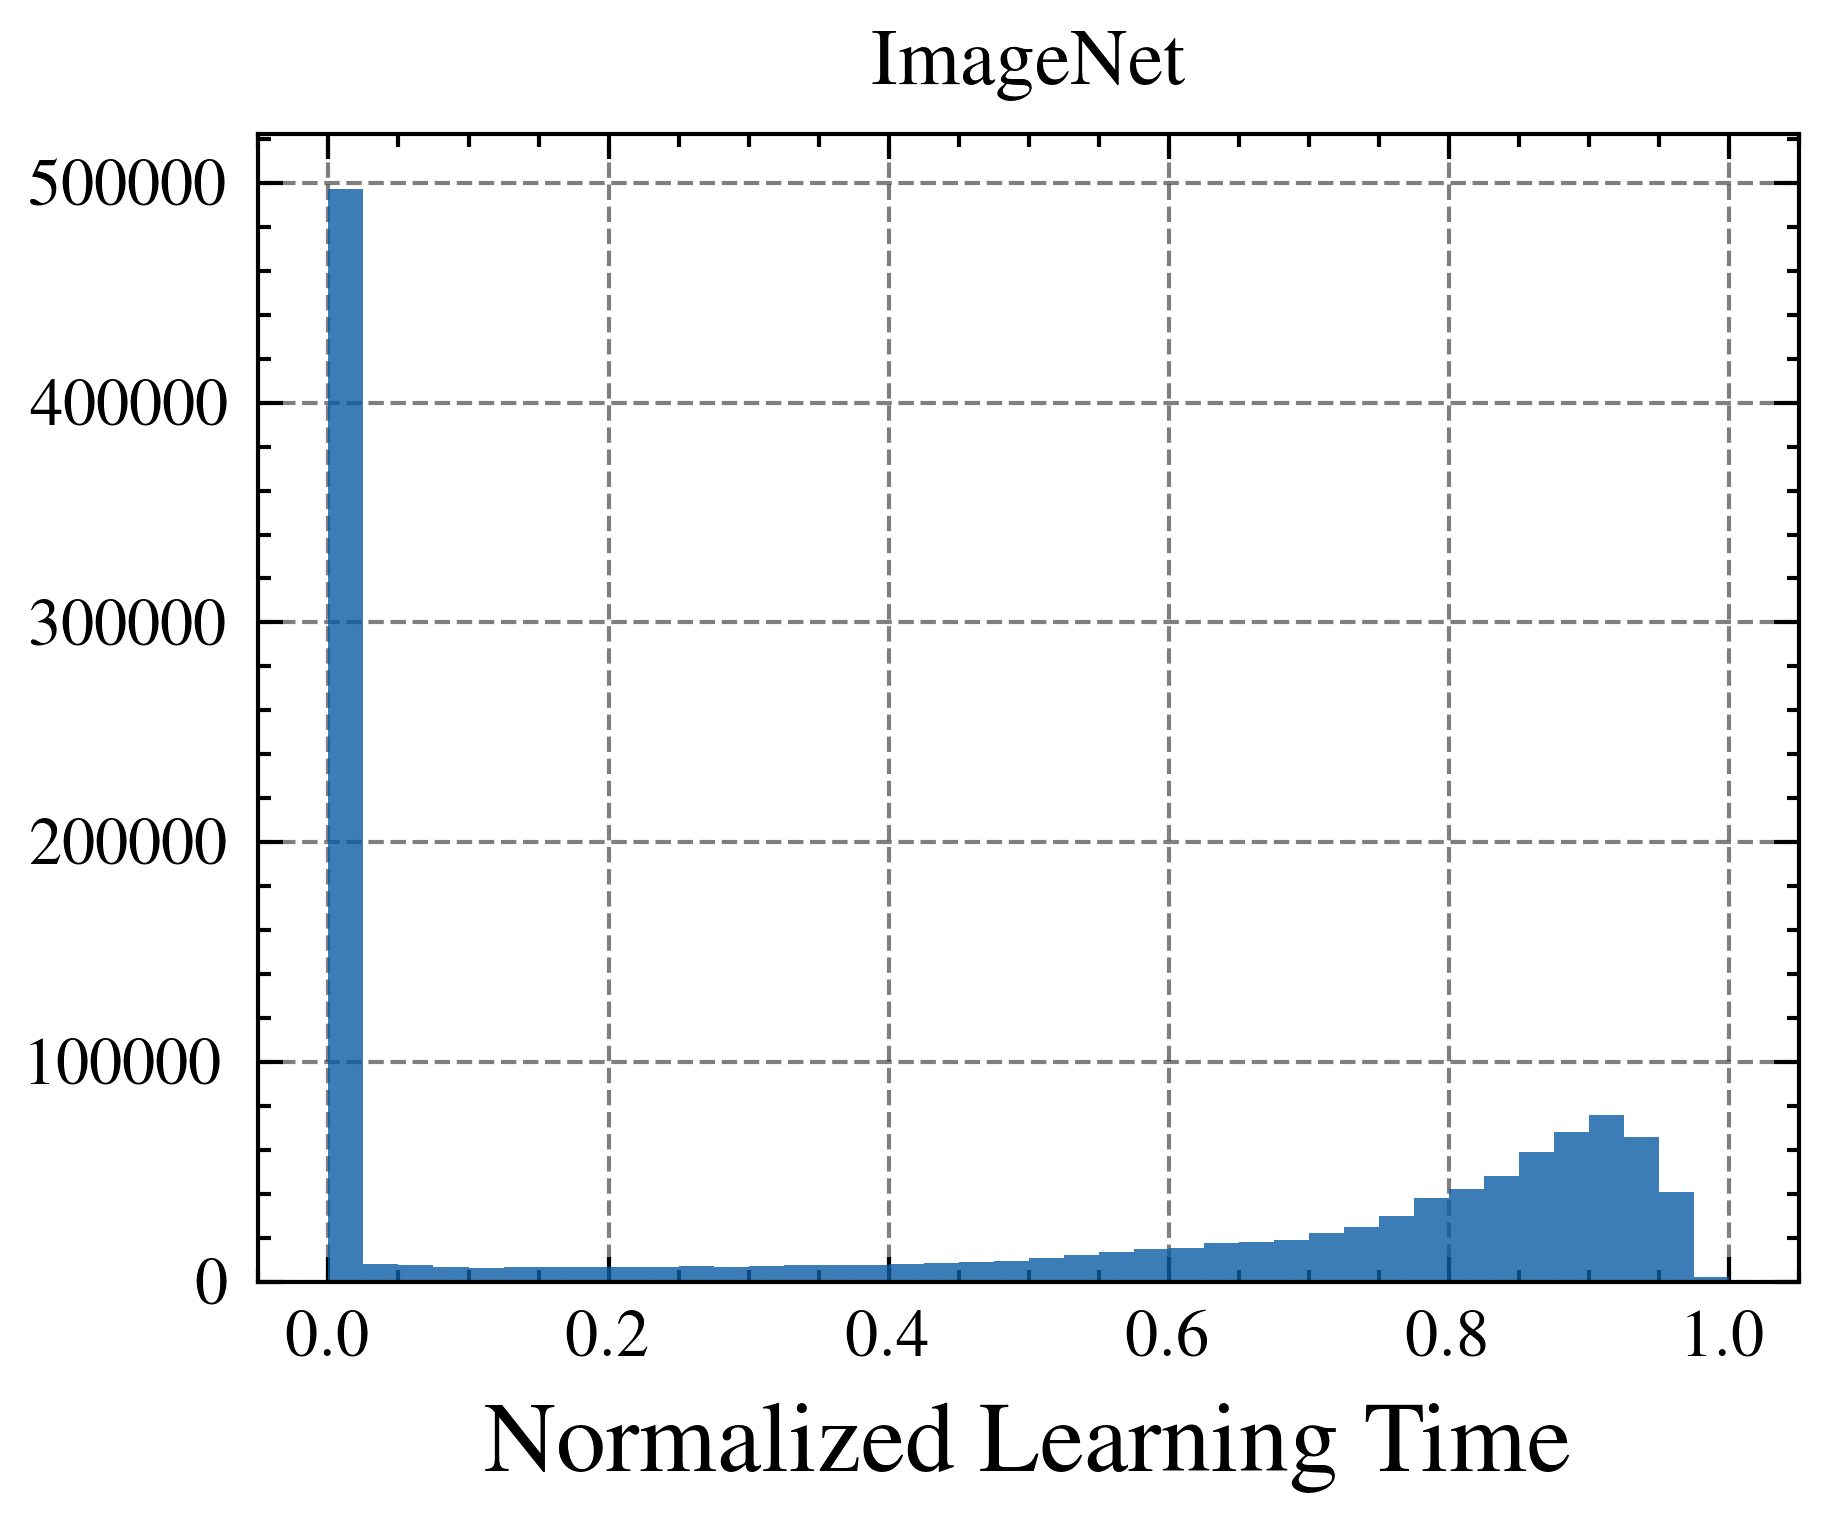

In [3]:
tau = learning_cond.mean() # threshold is the average per iteration sample grad
below_threshold = (learning_cond < tau)
lt = 1 - np.mean(below_threshold, axis=0) # expected lt is roughly the average of when it was learnt
# Define font size
font_size = 12

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['ieee', 'science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))

plt.hist(lt, bins=40, alpha=0.8)
plt.xlabel('Normalized Learning Time', fontsize=font_size)
plt.title('ImageNet')
plt.savefig('./output/lt_bimodal_imagenet.png')
plt.show()

/tmp/ipykernel_7884/1533467621.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gp = fz_scores.groupby('tr_mem_bin').mean()  # Group by tr_mem_bin and calculate mean
/tmp/ipykernel_7884/1533467621.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gp_std = fz_scores.groupby('tr_mem_bin').std()


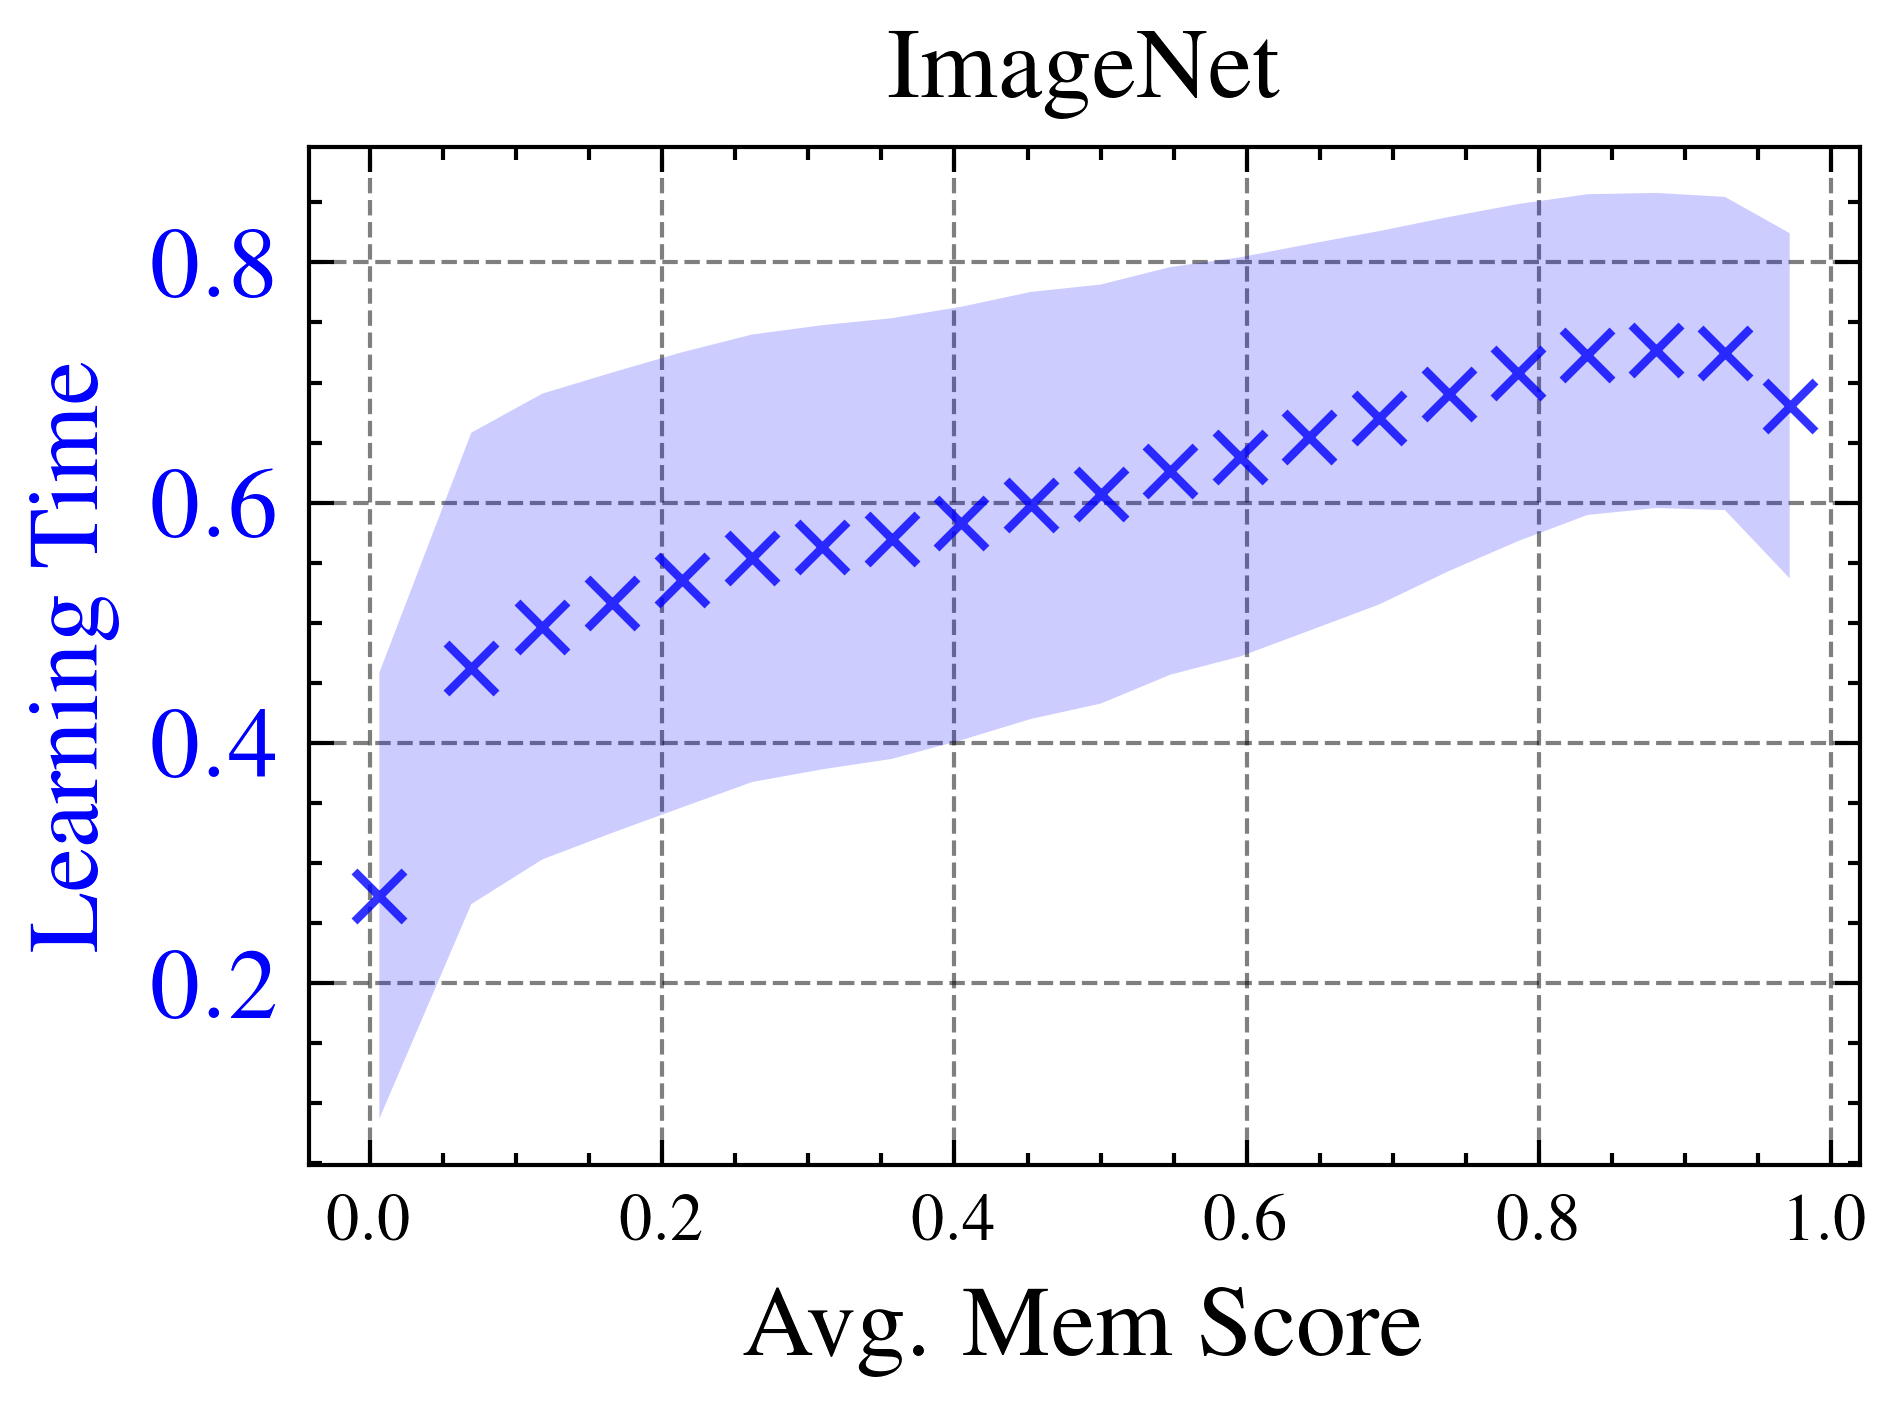

In [20]:
import pandas as pd

tf_2_torch_idx = pd.read_pickle("./mislabelled_exps/tf_id_2_torch_id2.pkl")
tf_2_torch_idx = tf_2_torch_idx['torch_id'].to_numpy()
# Convert dataset order from tensorflow to pytorch. Needed because FZ use tensorflow, while this repo uses Pytorch
npz = np.load('./analysis_checkpoints/imagenet/imagenet_index.npz', allow_pickle=True)
fz_scores = pd.DataFrame.from_dict({item: npz[item] for item in ['tr_labels', 'tr_mem']})
fz_scores['loss'] = losses.sum(0)
fz_scores['lt'] =  lt
num_bins = 21
bins = np.linspace(0, 1, num_bins+1)  # Generate bins between 0 and 1
labels = [f'{round(bins[i],3)}-{round(bins[i+1],3)}' for i in range(len(bins)-1)]  # Generate bin labels
fz_scores['tr_mem_bin'] = pd.cut(fz_scores['tr_mem'], bins=bins, labels=labels, include_lowest=True)
gp = fz_scores.groupby('tr_mem_bin').mean()  # Group by tr_mem_bin and calculate mean
gp_std = fz_scores.groupby('tr_mem_bin').std()
plt.style.use(['ieee', 'science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
fz_scores = fz_scores.iloc[tf_2_torch_idx]

ax1 = fig.gca()

# Define font size
font_size = 12

y_metric = 'lt'
x_metric = 'tr_mem'
x = gp[x_metric]
y = gp[y_metric]
y_std = 0.5 * gp_std[y_metric]
color = 'b'

ax1.set_ylabel('', color=color, fontsize=font_size)
ax1.scatter(x, y, color=color, alpha=0.8, marker='x', label='lt')
ax1.fill_between(x, y - y_std, y + y_std, color=color, alpha=0.2, edgecolor=None)  # Shaded area without outline
ax1.tick_params(axis='y', labelcolor=color, labelsize=font_size)

ax1.set_xlabel('Avg. Mem Score', fontsize=font_size)
ax1.set_ylabel('Learning Time', fontsize=font_size)
plt.title('ImageNet', fontsize=font_size)
plt.tight_layout()
plt.savefig("./output/lt_v_mem_imagenet_error_120.png")
plt.show()

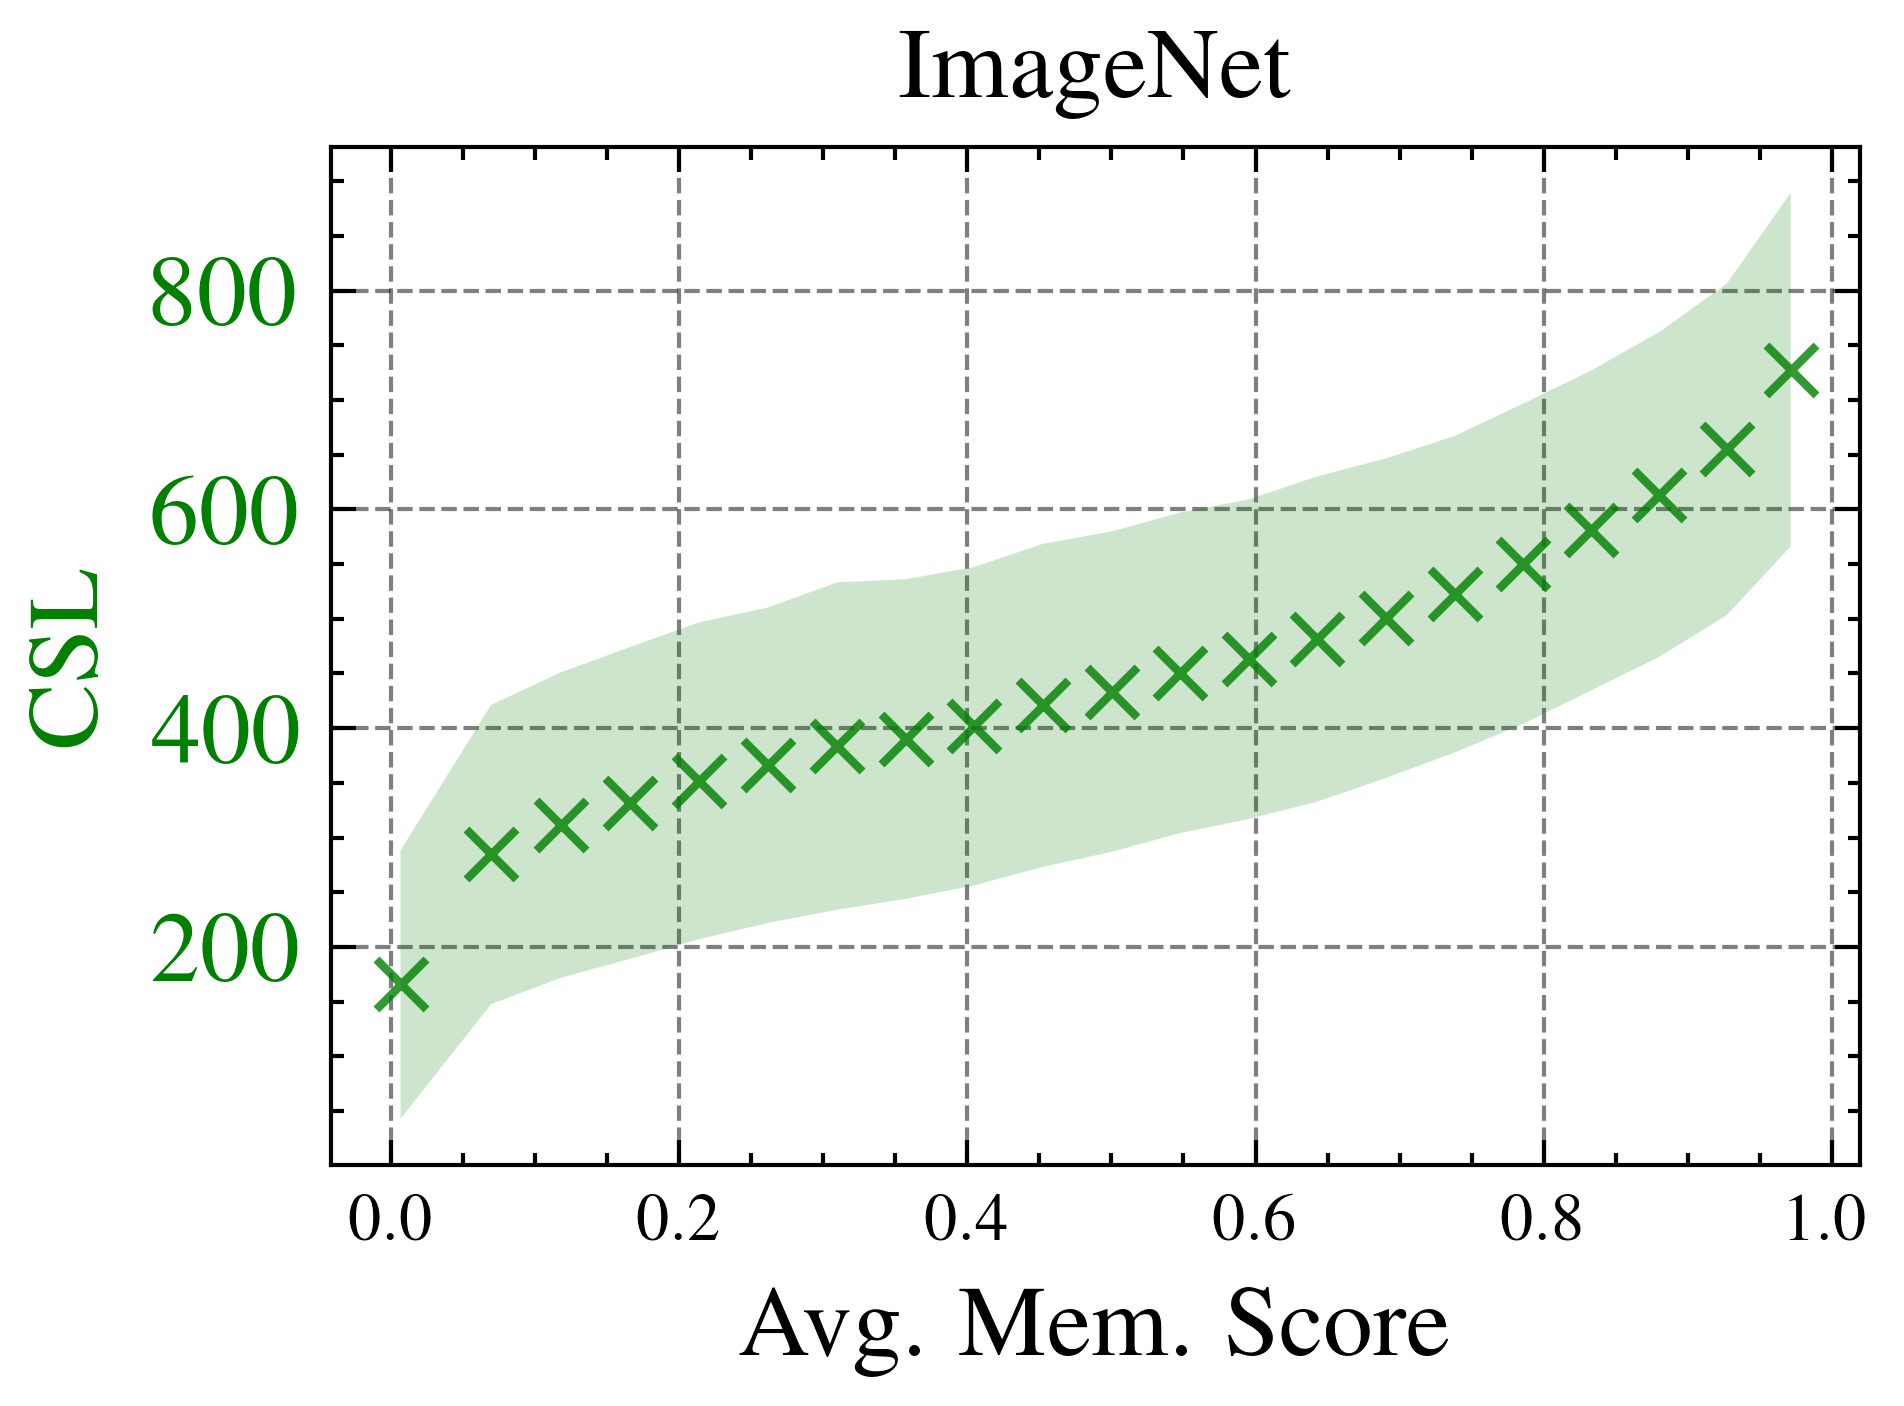

In [22]:
import scienceplots
plt.style.use(['ieee', 'science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
fz_scores = fz_scores.iloc[tf_2_torch_idx]
# fig, ax1 = plt.subplots()
ax1 = fig.gca()

# Define font size
font_size = 12

y_metric = 'loss'
x_metric = 'tr_mem'
x = gp[x_metric]
y = gp[y_metric]
y_std = 0.5 * gp_std[y_metric]
color = 'g'

ax1.set_ylabel('', color=color, fontsize=font_size)
ax1.scatter(x, y, color=color, alpha=0.8, marker='x', label='lt')
ax1.fill_between(x, y - y_std, y + y_std, color=color, alpha=0.2, edgecolor=None)  # Shaded area without outline
ax1.tick_params(axis='y', labelcolor=color, labelsize=font_size)

ax1.set_ylabel('CSL', fontsize=font_size)
ax1.set_xlabel('Avg. Mem. Score', fontsize=font_size)
plt.title('ImageNet', fontsize=font_size)
plt.tight_layout()
# plt.savefig("./output/mem_v_metric.svg")
# plt.savefig("./output/mem_v_metric.png")
plt.savefig("./output/mem_v_csl_tau_imagenet_error_120_2.png")
plt.show()

/tmp/ipykernel_7884/68437407.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gp = fz_scores.groupby('lt_bin').mean()  # Group by tr_mem_bin and calculate mean
/tmp/ipykernel_7884/68437407.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gp_std = fz_scores.groupby('lt_bin').std()


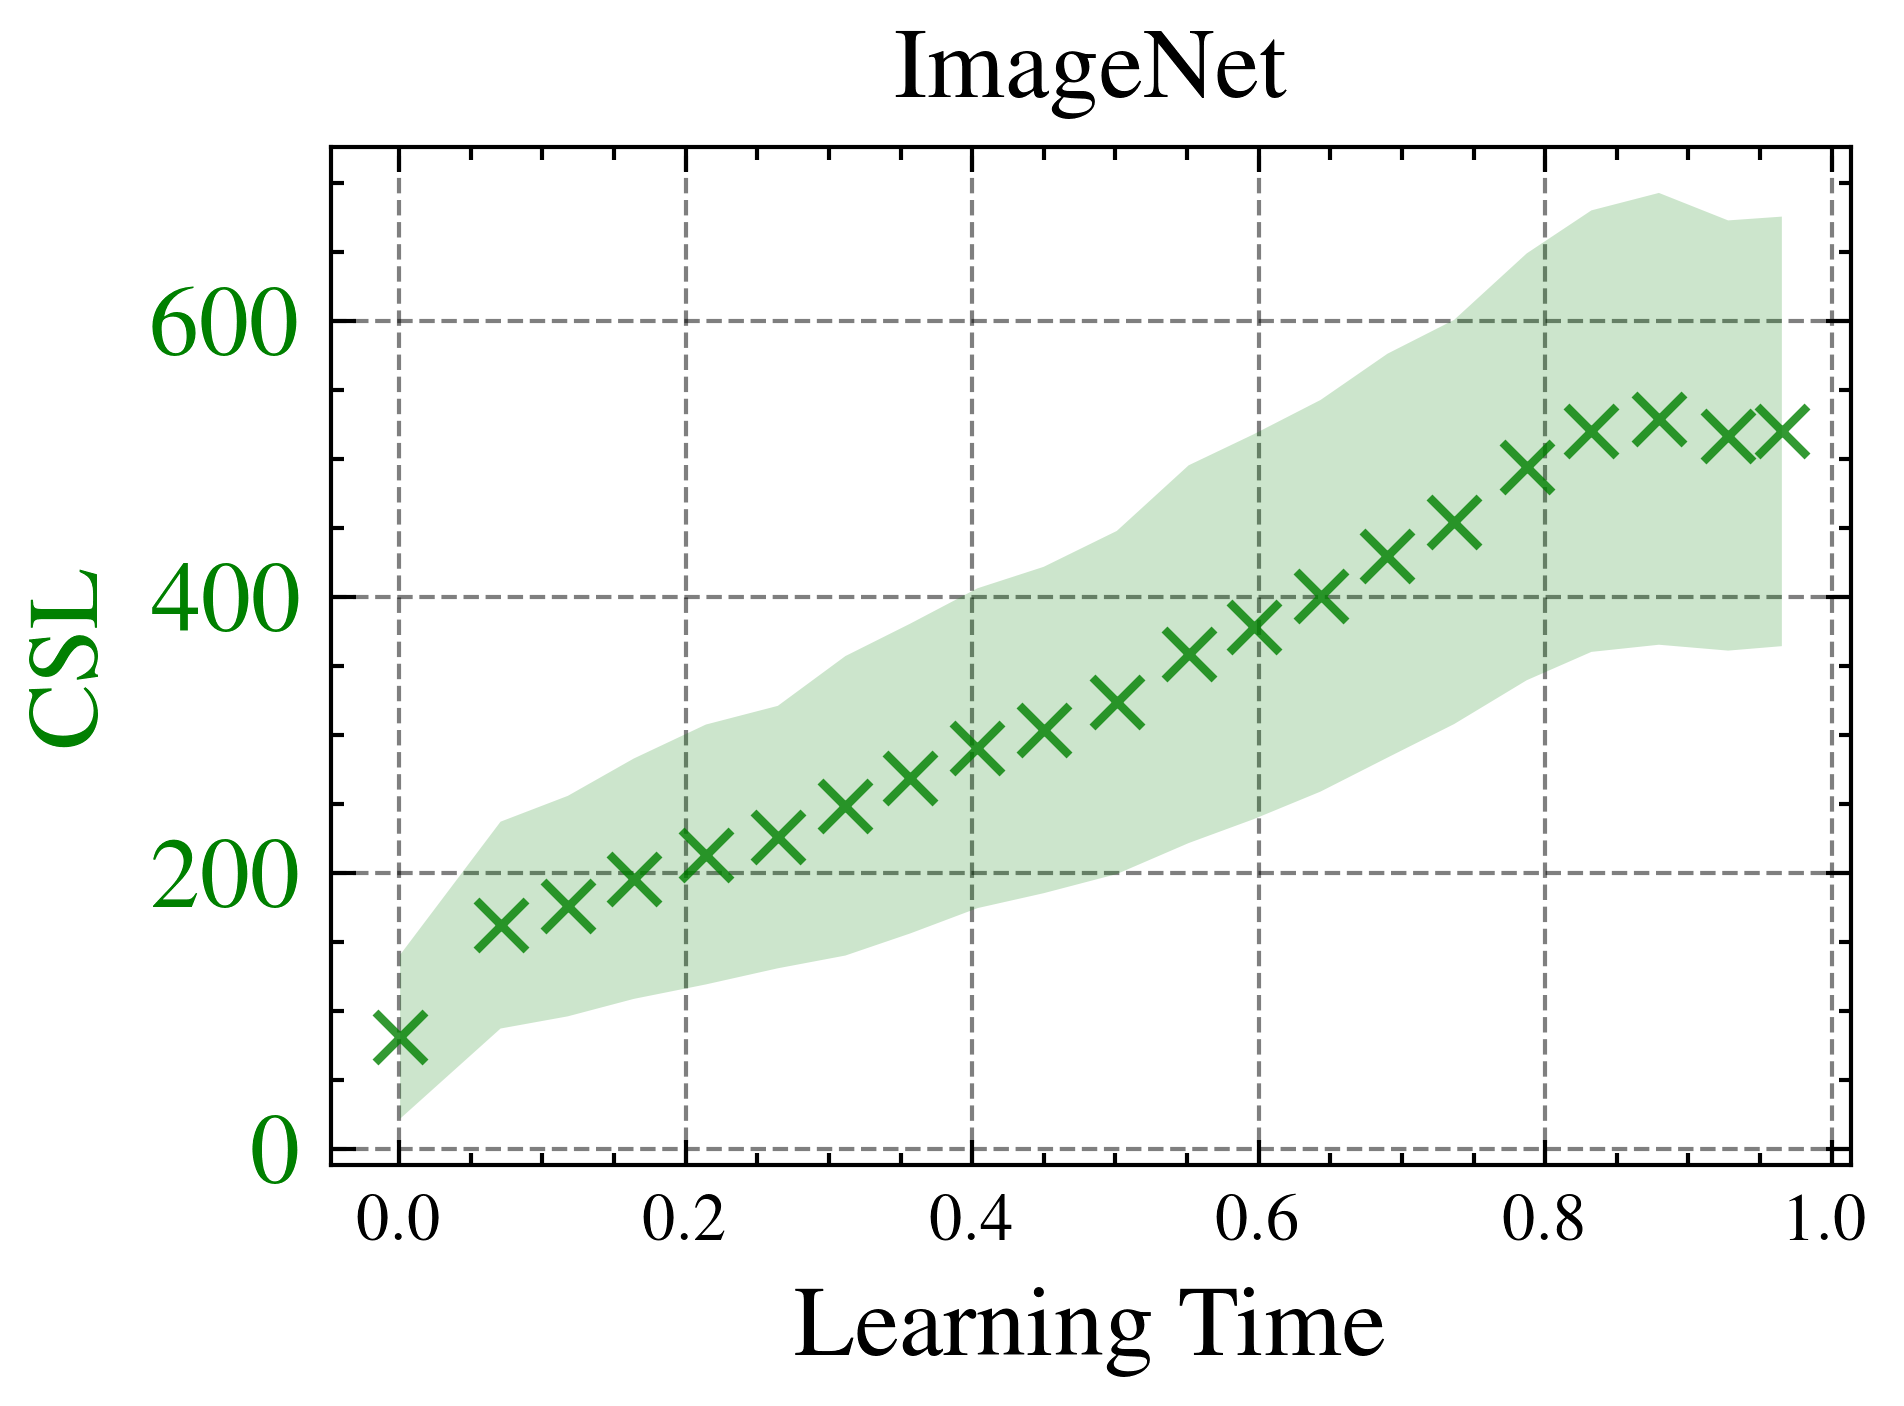

In [18]:
npz = np.load('./analysis_checkpoints/imagenet/imagenet_index.npz', allow_pickle=True)
fz_scores = pd.DataFrame.from_dict({item: npz[item] for item in ['tr_labels', 'tr_mem']})
fz_scores['loss'] = losses.sum(0)
fz_scores['loss_grad'] = loss_grads.mean(0)
fz_scores['lt'] =  lt

num_bins = 21
bins = np.linspace(0, 1, num_bins+1)  # Generate bins between 0 and 1
labels = [f'{round(bins[i],3)}-{round(bins[i+1],3)}' for i in range(len(bins)-1)]  # Generate bin labels
fz_scores['lt_bin'] = pd.cut(fz_scores['lt'], bins=bins, labels=labels, include_lowest=True)
gp = fz_scores.groupby('lt_bin').mean()  # Group by tr_mem_bin and calculate mean
gp_std = fz_scores.groupby('lt_bin').std()

import scienceplots
plt.style.use(['ieee', 'science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
fz_scores = fz_scores.iloc[tf_2_torch_idx]
# fig, ax1 = plt.subplots()
ax1 = fig.gca()

# Define font size
font_size = 12

y_metric = 'loss'
x_metric = 'lt'
x = gp[x_metric]
y = gp[y_metric]
y_std = 0.5 * gp_std[y_metric]
color = 'g'

ax1.set_ylabel('', color=color, fontsize=font_size)
ax1.scatter(x, y, color=color, alpha=0.8, marker='x', label='lt')
ax1.fill_between(x, y - y_std, y + y_std, color=color, alpha=0.2, edgecolor=None)  # Shaded area without outline
ax1.tick_params(axis='y', labelcolor=color, labelsize=font_size)

ax1.set_ylabel('CSL', fontsize=font_size)
ax1.set_xlabel('Learning Time', fontsize=font_size)
plt.title('ImageNet', fontsize=font_size)
plt.tight_layout()
# plt.savefig("./output/mem_v_metric.svg")
# plt.savefig("./output/mem_v_metric.png")
plt.savefig("./output/lt_v_csl_tau_imagenet_error_120.png")
plt.show()